In [3]:
https://medium.com/streamlit/creating-repeatable-items-in-streamlit-cb8b6264e1e6

50.0

In [79]:
from typing import Optional
import pandas as pd
from src.backend import data
import plotly_express as px


class Regime(dict):
    def get_state(self, date: Optional[pd.Timestamp] = None) -> str:
        del date
        raise NotImplementedError("Must implement fit for data")


class UsLeadingIndicatorRegime(Regime):
    def get_state(self, date: Optional[pd.Timestamp] = None) -> str:
        lei = data.get_macro("USALOLITONOSTSAM").resample("M").last().iloc[:, 0]
        lei.index = lei.index + pd.DateOffset(months=1)
        rate_of_change = lei.diff().ewm(span=3).mean()
        states = rate_of_change.map(lambda x: 1 if x > 0.00 else 0)
        
        px.line(states).update_layout(hovermode="x unified").show()


UsLeadingIndicatorRegime().get_state()

2000-01-31 00:00:00
0.08114226186540258
Reflation
2000-02-29 00:00:00
0.10535186045784177
Reflation
2000-03-31 00:00:00
0.2259257912397139
Reflation
2000-04-30 00:00:00
0.16142221478532093
Reflation
2000-05-31 00:00:00
0.09964399904594991
Reflation
2000-06-30 00:00:00
0.10586618113636379
Reflation
2000-07-31 00:00:00
0.05553194928408933
Reflation
2000-08-31 00:00:00
0.008697497492395682
Reflation
2000-09-30 00:00:00
0.078107721789454
Reflation
2000-10-31 00:00:00
0.014447429922951387
Reflation
2000-11-30 00:00:00
-0.051298453771494
Reflation
2000-12-31 00:00:00
-0.015536942048341506
Reflation
2001-01-31 00:00:00
0.050914693081352776
Reflation
2001-02-28 00:00:00
0.033401469791381845
Reflation
2001-03-31 00:00:00
-0.05138501424447905
Reflation
2001-04-30 00:00:00
-0.07663150884490143
Reflation
2001-05-31 00:00:00
-0.040585024699207536
Reflation
2001-06-30 00:00:00
-0.06569728744732141
Reflation
2001-07-31 00:00:00
-0.08743731979931171
Reflation
2001-08-31 00:00:00
-0.09040898454345123
R

<AxesSubplot:xlabel='DATE'>

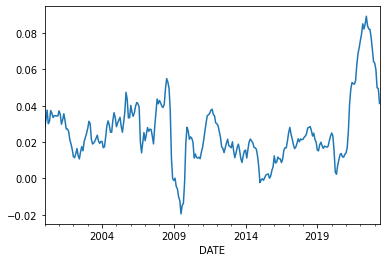

In [19]:
from src.core.regimes import Regime
from src.backend import data
import numpy as np


class InflationRegime(Regime):
    states = ("Disinflation", "Fire", "Ice", "Reflation")

    def fit(self) -> None:
        self.data = (
            data.get_macro("CPIAUCSL").resample("M").last().pct_change(12).dropna()
        ).iloc[:, 0]

    def get_state(self, date=None):
        if self.data.empty:
            self.fit()

        if date is not None:
            d = self.data.loc[:date]
        else:
            d = self.data
        slope, _ = np.polyfit(
            np.arange(len(d.iloc[-6:])), d.iloc[-6:].values * 100, deg=1
        )
        print(slope)

        low = d.iloc[-12 * 10:].quantile(q=0.10)
        high = d.iloc[-12 * 10:].quantile(q=0.90)
            

        if d.iloc[-12:].min() < 0.02 and slope >= 0.3:
            return "Fire"

        if d.iloc[-12:].max() < 0.05 and  slope <= -0.3:
            return "Ice"
        
        if d.iloc[-1] > 0.02:
            return "Reflation"
        
        return "Disinflation"

import pandas as pd
regime = InflationRegime()
start = "2000-1-1"
for date in pd.date_range(start, "2023-6-30", freq="M"):
    print(date)
    print(regime.get_state(date))
    
regime.data.loc[start:].plot()

<AxesSubplot:xlabel='DATE'>

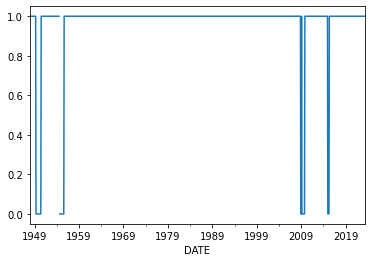

In [25]:
import pandas as pd

# Assuming you have a Pandas Series named 'inflation_yoy' containing YoY inflation data

# Calculate trailing 12-month percent change
inflation_pct_change = (
    data.get_macro("CPIAUCSL")
    .resample("M")
    .last()
    .pct_change(12)
    .dropna()
    .iloc[:, 0]
    * 100
)

# Initialize the category column
category = pd.Series(index=inflation_pct_change.index, dtype=str)

# Determine the categories
for i in range(len(inflation_pct_change)):

    if inflation_pct_change.iloc[i] < 0 and category.iloc[i - 1] != -1:
        category[i] = 0
    elif inflation_pct_change.iloc[i] > 0 and category.iloc[i - 1] != 4:
        category[i] = 1
    elif inflation_pct_change.iloc[i] > 2:
        if inflation_pct_change.iloc[i] <= 5 and (
            inflation_pct_change.iloc[i] >= inflation_pct_change[i - 1]
        ):
            category[i] = 4
    elif inflation_pct_change.iloc[i] < 1:
        if inflation_pct_change.iloc[i] <= -1 and (
            inflation_pct_change.iloc[i] >= inflation_pct_change[i - 1]
        ):
            category[i] = -1
# Print the categories
category.plot()

In [6]:
from src.core import universes
import pandas as pd
import streamlit as st

universe = pd.DataFrame(universes.UnitedStatesSectors().ASSETS)

assetclasses = universe.assetclass.unique()

constraints = []

for assetclass in assetclasses:
    minimum = st.number_input(
        label=f"Min {assetclass}", min_value=0, max_value=100, value=0
    )
    maximum = st.number_input(
        label=f"Max {assetclass}", min_value=0, max_value=100, value=100
    )

    constraints.append(
        {
            "assets": universe[universe["assetclass"] == assetclass]["ticker"],
            "bounds": {minimum / 100, maximum / 100},
        }
    )

,ticker,assetclass,name
0,XLC,Equity,Communication Services Select Sector SPDR Fund
1,XLY,Equity,Consumer Discretionary Select Sector SPDR Fund
2,XLP,Equity,Consumer Staples Select Sector SPDR Fund
3,XLE,Equity,Energy Select Sector SPDR Fund
4,XLF,Equity,Financial Select Sector SPDR Fund
5,XLV,Equity,Health Care Select Sector SPDR Fund
6,XLI,Equity,Industrial Select Sector SPDR Fund
7,XLB,Equity,Materials Select Sector SPDR Fund
8,XLRE,Equity,Real Estate Select Sector SPDR Fund
9,XLK,Equity,Technology Select Sector SPDR Fund


In [37]:
from src.core import regimes
from src.backend import data

regime = regimes.VixRegime()

regime.set_state_constraint("NormalVol", {"portfolio": "EqualWeight"})
regime.set_state_constraint("ExtremeVol", {"portfolio": "MinCorr"})


fwd = data.get_price("ACWI").resample("D").last().pct_change(21).shift(-21).dropna()


import pandas as pd

norm = {}
extr = {}

# for date in pd.date_range("2015-1-1", "2023-6-30", freq="D"):
for date in fwd.index:
    state = regime.get_state(date=date)
    if state == "ExtremeVol":
        extr[str(date)] = fwd.loc[date]
    else:
        norm[str(date)] = fwd.loc[date]

print(pd.Series(extr).mean())
print(pd.Series(norm).mean())

0.007421424624122381
0.003335426178051909


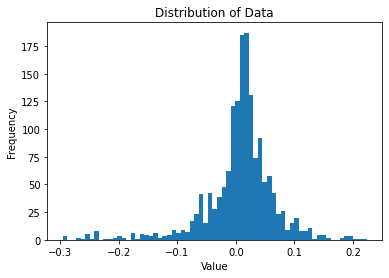

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a Pandas Series
data = pd.Series(extr)

# Plot the histogram
plt.hist(data, bins="auto")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of Data")
plt.show()

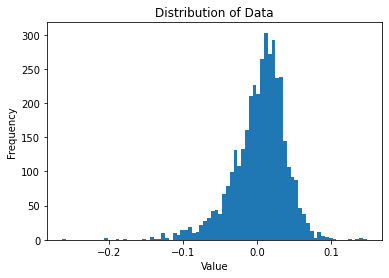

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a Pandas Series
data = pd.Series(norm)

# Plot the histogram
plt.hist(data, bins="auto")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of Data")
plt.show()

In [ ]:
import statsmodels.api as sm
import numpy as np
import yfinance as yf

for n in range(1, 100):
    prices = yf.download("SPY")["Adj Close"].resample("M").last().iloc[-(n + 12) : -n]
    prices = prices / prices.iloc[0] - 1
    prices.plot()
    x = sm.add_constant(
        np.arange(len(prices))
    )  # Create an array of indices corresponding to the range
    model = sm.OLS(prices, x).fit()
    print(n, model.params)

In [ ]:
from src.core.strategies import MultiStrategy

multi = MultiStrategy().load_files()

multi.performance.plot()

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Create a sample DataFrame with multiple stock prices
df = pd.DataFrame(
    {
        "Date": pd.date_range(start="2022-01-01", periods=5, freq="D"),
        "Price_Stock1": [100, 110, 120, 130, 140],
        "Price_Stock2": [80, 85, 90, 95, 100],
        "Price_Stock3": [70, 75, 80, 85, 90],
    }
)

# Calculate the price changes for each stock
df[["Price_Change_Stock1", "Price_Change_Stock2", "Price_Change_Stock3"]] = df.iloc[
    :, 1:4
]


# Define the dependent variables (stock price changes) and the independent variable (index price changes)
y = df[["Price_Change_Stock1", "Price_Change_Stock2", "Price_Change_Stock3"]]
X = sm.add_constant(np.ones(len(df)))

# Perform the multi-variable regression
model = sm.OLS(y, X)
results = model.fit()

# Extract the beta coefficients
beta_coefficients = results.params[1:]  # Exclude the constant term

# Print the beta coefficients
print("Beta coefficients:")
print(beta_coefficients)

In [ ]:
from src.backend import data
from src.core import metrics
import pandas as pd

std = data.get_prices("SPY").pct_change().ewm(21).std()
fwd = data.get_prices("SPY").pct_change(21).shift(-21)
dd = pd.concat([std, fwd], axis=1).dropna().apply(metrics.to_standard_scaler, axis=0)

In [ ]:
dd.loc["2018"].plot()

In [ ]:
class VolatilityState:
    lookback: int = 252 * 10

    def __init__(self) -> None:
        self.data = pd.DataFrame()

In [ ]:
from src.backend import data


class NormalizedVixLevel:
    def __init__(self) -> None:
        self.data = pd.Series()

    def fit(self):
        self.data = data.get_price("^VIX")

    def get_state(self, date=None):
        if self.data.empty:
            self.fit()

        if date is not None:
            d = self.data.loc[:date]
        else:
            d = self.data
        d = d.iloc[-252 * 10 :]
        score = (d.iloc[-1] - d.mean()) / d.std()
        # score = score.iloc[0]
        if score >= 0.8 or score <= -0.8:
            return "extreme"
        return "med"


fwd = data.get_price("ACWI").resample("D").last().pct_change(21).shift(-21).dropna()


import pandas as pd

norm = {}
extr = {}

# for date in pd.date_range("2015-1-1", "2023-6-30", freq="D"):
for date in fwd.index:
    state = NormalizedVixLevel().get_state(date)
    if state == "extreme":
        extr[str(date)] = fwd.loc[date]
    else:
        norm[str(date)] = fwd.loc[date]

print(pd.Series(extr).mean())
print(pd.Series(norm).mean())

In [ ]:
fwd

In [ ]:
from src.backend import data


class VixState:
    def __init__(self) -> None:
        self.data = pd.DataFrame()

    def fit(self):
        self.data = data.get_prices("^VIX")

    def get_state(self, date=None):
        if self.data.empty:
            self.fit()

        if date is not None:
            d = self.data.loc[:date]
        else:
            d = self.data
        d = d.iloc[-252 * 10 :]
        score = (d.iloc[-1] - d.mean()) / d.std()
        score = score.iloc[0]
        if score >= 0.8 or score <= -0.8:
            return "extreme"
        return "med"


fwd = data.get_price("SPY").resample("M").last().pct_change(1).shift(-1)


import pandas as pd

norm = {}
extr = {}

for date in pd.date_range("2015-1-1", "2023-7-1", freq="M"):
    state = VixState().get_state(date)
    if state == "extreme":
        extr[str(date)] = fwd.loc[date]
    else:
        norm[str(date)] = fwd.loc[date]

print(pd.Series(extr).median())
print(pd.Series(norm).median())

In [ ]:
from src import factors

In [ ]:
test.performance_alpha.plot()

In [ ]:
from src.core.strategies.multi import MultiStrategy
from src import core

multis = MultiStrategy().add_strategy(
    inception="2008-1-1",
    universe=core.universes.UnitedStatesSectors(),
    benchmark=core.benchmarks.UnitedStatesSectorsEW(),
    factor=(core.factors.PxMom1M(), core.factors.PriceMomentum12M()),
)
stra = multis["Strategy(1)"]
stra.get_signature()

In [ ]:
stra.save("test", True)

In [ ]:
multis = MultiStrategy().load_files()
multis.performance.plot()

In [ ]:
multis.performance_alpha.plot()

In [ ]:
from src.core.factors import MultiFactors
from src.core import factors

sa = MultiFactors("PriceMomentum1M", "PriceMomentum18M")

In [ ]:
sa.get_factor_by_date(tickers="SPY, AGG, TLT, GSG, IEF, ACWI, IWV", date="2023-1-3")

In [ ]:
import logging

logger = logging.getLogger("test")
from src.core.strategies.multi import MultiStrategy

logger.warning("import finished")
multis = MultiStrategy().load_files()
multis.performance.plot()

In [ ]:
import pandas as pd

pd.date_range(start=pd.Timestamp("now"), freq="M")

In [ ]:
multis["Strategy(1)"].book.records.allocations

In [ ]:
import pandas as pd

# Create a sample Series
data = pd.Series([1, 2, 3, 4, 5])

# Empty the Series by assigning an empty list
data = pd.Series([])

# Verify that the Series is empty
print(data)

In [ ]:
import numpy as np
from scipy import stats


def factor_information_coefficient(
    factor_data, group_adjust=False, by_group=False, method=stats.spearmanr
):
    def src_ic(group):
        f = group["factor"]
        _ic = group[["period_1", "period_252"]].apply(lambda x: method(x, f)[0])
        return _ic

    factor_data = factor_data.copy()

    grouper = [factor_data.index.get_level_values("date")]

    # if group_adjust:
    #     factor_data = demean_forward_returns(factor_data, grouper + ['group'])
    # if by_group:
    #     grouper.append('group')

    with np.errstate(divide="ignore", invalid="ignore"):
        ic = factor_data.groupby(grouper).apply(src_ic)

    return ic


ic = factor_information_coefficient(far.clean_factor_data)

ic.plot()

In [ ]:
ic.mean()

In [ ]:
far = ja.FactorAnalyzer(
    prices=prices,
    factor=factorsdata,  # factor_data 为因子值的 pandas.DataFrame
    quantiles=10,
    periods=(1, 252),
    max_loss=0.9,
)

far

In [ ]:
far._clean_factor_data

In [ ]:
from pkg.src.core import signals, data
import pandas as pd

df = data.get_oecd_us_leading_indicator()
df.index = df.index + pd.DateOffset(months=1)
df = df.resample("M").last().dropna()

df = df.diff()
mean = df.rolling(12 * 5).mean()
std = df.rolling(12 * 5).std()
normalized = (df - mean) / std

normalized = normalized.clip(-3, 3).dropna()

import plotly.graph_objects as go


# Create the bar plot
fig = go.Figure(data=go.Bar(x=normalized.index, y=normalized["USALOLITONOSTSAM"]))

# Customize the plot layout
fig.update_layout(title="Bar Plot", xaxis_title="Categories", yaxis_title="Values")

# Display the plot
fig.show()

In [ ]:
normalized

In [ ]:
trend.loc["2015"]

In [ ]:
from pkg.src.core import data, metrics
import numpy as np
import pandas as pd

total_iter = 12 * 20 * 10
prices = data.get_prices("SPY, AGG, TLT").resample("M").last()

log_return = metrics.to_log_return(prices=prices)
expected_return = log_return.mean()
expected_riks = log_return.std()
cov = log_return.cov()
corr_cov = np.linalg.cholesky(cov)
z = np.random.normal(0, 1, size=(len(prices.columns), total_iter))

drift = np.full((total_iter, len(prices.columns)), expected_return).T
shock = np.dot(corr_cov, z)

monthly_returns = drift + shock
pd.DataFrame(
    np.transpose(monthly_returns),
    columns=prices.columns,
    # index=pd.date_range(start="2023-6-8", periods=total_iter, freq="M"),
).cumsum().plot()

In [ ]:
import pandas as pd


def to_macd(
    prices: pd.DataFrame,
    fast_window: int = 12,
    slow_window: int = 26,
    signal_window: int = 9,
) -> pd.DataFrame:
    MACD = (
        +prices.ewm(span=fast_window, min_periods=fast_window).mean()
        - prices.ewm(span=slow_window, min_periods=slow_window).mean()
    )
    signal = MACD.ewm(span=signal_window, min_periods=slow_window).mean()

    return signal


to_macd(prices).loc["2022"].plot()

In [ ]:
(
    prices.ewm(span=12, min_periods=12).mean()
    - prices.ewm(span=26, min_periods=26).mean()
).plot()

In [ ]:
yield_curve = {"T10Y2Y": "10Y-2Y", "T10Y3M": "10Y-3M"}

yield_curve_data = data.get_macro(list(yield_curve.keys())).loc["2019":]
yield_curve_data = yield_curve_data.rename(columns=yield_curve)
yield_curve_data.head().to_markdown()

In [ ]:
import plotly_express as px

px.line(yield_curve_data)

In [ ]:
my_list = [10, 20, 30, 40, 50]

# Get the index of a value in the list
value = 30

if value in my_list:
    index = my_list.index(value)
    print("Index of", value, "in the list:", index)
else:
    print(value, "is not present in the list.")

In [ ]:
from pkg.src.core.factors import price_momentum_diffusion
from pkg.src.core import data

price_momentum_diffusion(tickers="SPY, ACWI, XLY, XLP, AGG")

In [ ]:
from pkg.src.core import metrics
import numpy as np
import pandas as pd

prices = data.get_prices(tickers="SPY, ACWI, XLY, XLP, AGG")
momentums = (
    pd.concat(
        objs=[
            metrics.rolling.to_momentum(prices=prices, months=1).stack(),
            metrics.rolling.to_momentum(prices=prices, months=2).stack(),
            metrics.rolling.to_momentum(prices=prices, months=3).stack(),
            metrics.rolling.to_momentum(prices=prices, months=6).stack(),
            metrics.rolling.to_momentum(prices=prices, months=9).stack(),
            metrics.rolling.to_momentum(prices=prices, months=12).stack(),
        ],
        axis=1,
    )
    .apply(np.sign)
    .sum(axis=1)
    .unstack()
)

momentums

In [ ]:
from pkg.src.core import factors

factors.volatility_3m(tickers="SPY, AGG")

In [ ]:
from pkg.src.core import data

data.get_universe()

In [ ]:
from pkg.src.core.metrics.rolling import to_momentum
from pkg.src.core import data
from pkg.src.core.strategies import BacktestManager
import pandas as pd
from scipy.stats import norm


def to_standard_scalar(features: pd.Series) -> pd.Series:
    scalar = (features - features.mean()) / features.std()
    return scalar


def to_standard_percentile(features: pd.Series) -> pd.Series:
    return to_standard_scalar(features=features).aggregate(norm.cdf)


prices = data.get_prices("XLC, XLY, XLP, XLE, XLF, XLV, XLI, XLB, XLRE, XLK, XLU")

bt = BacktestManager(prices=prices)
features = to_momentum(prices=prices, months=12).apply(to_standard_percentile, axis=1)

bt.Base(name="Strategy1", start="2013-1-1", features=features, percentile=0.8)
#
bt.strategies["Strategy1"].allocations
# features
bt.strategies["Strategy1"].value.plot()

In [ ]:
from pkg.src.core import feature

functions = [func for func in dir(feature) if callable(getattr(feature, func))]
functions

In [ ]:
pri_momentum = data.price_momentum_1m(tickers="SPY, AGG")
pri_momentum

In [ ]:
import json

# from core.signals import OECDUSLEIHP
from pkg.core.strategies import BacktestManager

# signal = OECDUSLEIHP.from_fred_data()


def get_universe(name: str = "USSECTOR"):
    with open("universe.json") as f:
        return json.load(f).get(name)


from pkg.src.core import data

prices = data.get_prices(tickers=list(get_universe().keys()))
bt = BacktestManager(prices=prices, start="2007-1-1", commission=10, shares_frac=0)
# bt.Momentum(target_percentile=0.7, months=3)
# bt.values.plot(figsize=(12, 10))
# bt.analytics

from core import metrics

metrics.to_momentum(prices=prices.iloc[:, 0], months=12, skip_months=1)

In [ ]:
from pkg.src.core import data


data.get_universe()

In [ ]:
opt = Optimizer.from_prices(prices=prices.loc["2017"].dropna(axis=1))

w = opt.hierarchical_risk_parity()

w

In [ ]:
from pkg.src.core.portfolios import objectives

np.sum(
    objectives.risk_contributions(
        weights=w,
        covariance_matrix=np.array(opt.covariance_matrix),
        sub_covariance_matrix_idx=[8],
    )
)

np.sum(
    objectives.risk_contributions(
        weights=w,
        covariance_matrix=np.array(opt.covariance_matrix),
        sub_covariance_matrix_idx=[0, 3],
    )
)

In [ ]:
objectives.expected_volatility(w, opt.covariance_matrix)

In [ ]:
dist = np.sqrt((1 - opt.correlation_matrix).round(5) / 2)
clusters = linkage(squareform(dist), method="single")
sorted_tree = list(to_tree(clusters, rd=False).pre_order())

print(sorted_tree)


def recursive_bisection(sorted_tree):
    """_summary_

    Args:
        sorted_tree (_type_): _description_

    Returns:
        List[Tuple[List[int], List[int]]]: _description_
    """

    left = sorted_tree[0 : int(len(sorted_tree) / 2)]
    right = sorted_tree[int(len(sorted_tree) / 2) :]

    if len(sorted_tree) < 3:
        return (left, right)

    cache = [(left, right)]
    if len(left) > 2:
        cache.extend(recursive_bisection(left))
    if len(right) > 2:
        cache.extend(recursive_bisection(right))
    return cache


cluster_sets = recursive_bisection(sorted_tree)

for i in cluster_sets:
    print(i)

In [ ]:
from core import data
import plotly.graph_objects as go
from plotly.subplots import make_subplots

tickers = {
    "T5YIE": "Breakeven Inflation: 5Y",
    "T10YIE": "Breakeven Inflation: 10Y",
    "T5YIFR": "Expectation Infaltiona: 5Y",
}

result = data.get_macro(tickers=tickers).dropna()
result["chg"] = result["Breakeven Inflation: 10Y"] - result["Breakeven Inflation: 5Y"]
spy = data.get_prices(tickers="SPY")

# Create a line plot for each series
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05)
fig.add_trace(
    go.Scatter(x=spy.index, y=spy["SPY"], mode="lines", name="SPY"), row=1, col=1
)
for series in result:
    fig.add_trace(
        go.Scatter(x=result.index, y=result[series], mode="lines", name=series),
        row=2,
        col=1,
    )

# Set the title and axis labels
fig.update_layout(title="Inflation", xaxis_title="Date", yaxis_title="%", height=600)
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1d", step="day", stepmode="backward"),
                    dict(count=7, label="1w", step="day", stepmode="backward"),
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=3, label="3m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider=dict(visible=False),
        type="date",
    ),
    hovermode="x unified",  # Enable the "Show All Stats" option on mouseover
)

# Display the graph
fig.show()

In [ ]:
from core.strategies import BacktestManager

bt = BacktestManager.from_universe(start="2010-1-1", commission=10, shares_frac=0)
bt.Momentum()
bt.values.plot()